# HDMA Excersise 1

## Structure



1.   Import libraries and data
2.   Data Exploration
3.   Experimenting with logistic regression and data transformations
4.   Using differnet Training Algorithms & choosing the best one
5.   Final Training and prediction

## 1. Import librariers and data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr, chi2_contingency
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense



train_data = pd.read_csv('hdma_train.csv')
test_data = pd.read_csv('hdma_test.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Data Exploration

In [ ]:
num_rows, num_columns = train_data.shape
print("Number of rows: ", num_rows)
print("Number of columns: ", num_columns)
train_data.head()

Number of rows:  2281
Number of columns:  14


,Unnamed: 0,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,condo,black,deny
0,0,0.221,0.221,0.800000,5.0,2.0,no,no,no,no,3.9,0,no,False
1,1,0.265,0.265,0.921875,2.0,2.0,no,no,no,yes,3.2,0,no,False
2,2,0.372,0.248,0.920398,1.0,2.0,no,no,no,no,3.2,0,no,False
3,3,0.320,0.250,0.860465,1.0,2.0,no,no,no,no,4.3,0,no,False
4,4,0.360,0.350,0.600000,1.0,1.0,no,no,no,no,3.2,0,no,False


In [ ]:
num_rows, num_columns = test_data.shape
print("Number of rows: ", num_rows)
print("Number of columns: ", num_columns)
test_data.head()

Number of rows:  100
Number of columns:  13


,Unnamed: 0,dir,hir,lvr,ccs,mcs,pbcr,dmi,self,single,uria,condo,black
0,12,0.280,0.270,0.537634,1.0,2.0,no,yes,no,no,4.3,0,no
1,63,0.279,0.208,0.751880,1.0,2.0,no,no,no,no,5.3,0,no
2,72,0.280,0.280,0.738255,1.0,2.0,no,no,no,yes,3.2,0,no
3,78,0.265,0.265,0.835165,2.0,2.0,yes,yes,no,no,4.3,0,no
4,82,0.310,0.310,0.882353,4.0,2.0,no,no,no,no,3.2,0,yes


## 2.1 Check for missing values and data types



In [ ]:
print("\nData types and null counts:")
summary = pd.DataFrame({
    'Data Type': train_data.dtypes,
    'Null Count': train_data.isnull().sum()
})
print(summary)
print()
rows_with_missing_values = train_data[train_data.isnull().any(axis=1)]

print("Rows with missing values:")
print(rows_with_missing_values)


Data types and null counts:
           Data Type  Null Count
Unnamed: 0     int64           0
dir          float64           0
hir          float64           0
lvr          float64           0
ccs          float64           0
mcs          float64           0
pbcr          object           1
dmi           object           0
self          object           1
single        object           0
uria         float64           0
condo          int64           0
black         object           0
deny            bool           0

Rows with missing values:
      Unnamed: 0       dir       hir       lvr       ccs       mcs pbcr dmi  \
2280        2380  0.330814  0.255346  0.700783  2.116387  1.721008  NaN  no   

     self single      uria  condo black   deny  
2280  NaN    yes  3.774496      0    no  False  


In [ ]:
print("\nData types and null counts:")
summary = pd.DataFrame({
    'Data Type': test_data.dtypes,
    'Null Count': test_data.isnull().sum()
})
print(summary)


Data types and null counts:
           Data Type  Null Count
Unnamed: 0     int64           0
dir          float64           0
hir          float64           0
lvr          float64           0
ccs          float64           0
mcs          float64           0
pbcr          object           0
dmi           object           0
self          object           0
single        object           0
uria         float64           0
condo          int64           0
black         object           0


Since it's only one observation in the train set with missing values, we're going to remove that observation

In [ ]:
train_data = train_data.dropna()

### Data types

According to the meta data, the variables pbcr, dmi, self, single, condo and black are all "Yes-or-No-Questions" so they should all be boolean. Let's look at them closer

In [ ]:
boolean_vars = ['pbcr', 'dmi', 'self', 'single', 'condo', 'black']

# Function to print unique values and counts for each boolean variable
def print_boolean_stats(df, var_list):
    for var in var_list:
        print(f"Statistics for variable '{var}':")
        unique_values = df[var].value_counts()
        print(unique_values)
        print()

print_boolean_stats(train_data, boolean_vars)

Statistics for variable 'pbcr':
pbcr
no     2120
yes     160
Name: count, dtype: int64

Statistics for variable 'dmi':
dmi
no     2243
yes      37
Name: count, dtype: int64

Statistics for variable 'self':
self
no     2011
yes     269
Name: count, dtype: int64

Statistics for variable 'single':
single
no     1387
yes     893
Name: count, dtype: int64

Statistics for variable 'condo':
condo
0    1633
1     647
Name: count, dtype: int64

Statistics for variable 'black':
black
no     1967
yes     313
Name: count, dtype: int64



We're going to transform all of them to Boolean as integer

In [ ]:
# remove condo, because it's already binary
boolean_vars = ['pbcr', 'dmi', 'self', 'single', 'black']

# Transform "Yes" to 1 and "No" to 0 for the specified variables
train_data[boolean_vars] = train_data[boolean_vars].replace({'yes': 1, 'no': 0})
test_data[boolean_vars] = test_data[boolean_vars].replace({'yes': 1, 'no': 0})

# Ensure they're of integer type
train_data[boolean_vars] = train_data[boolean_vars].astype(int)
test_data[boolean_vars] = test_data[boolean_vars].astype(int)

# Put condo back to the array
boolean_vars.append("condo")

## 2.2 Data Distribution and Correlation of explaining variables

From now on we're only going to look at the train_data, since we consider the train_data as not available

### 2.2.1 Categorical Features



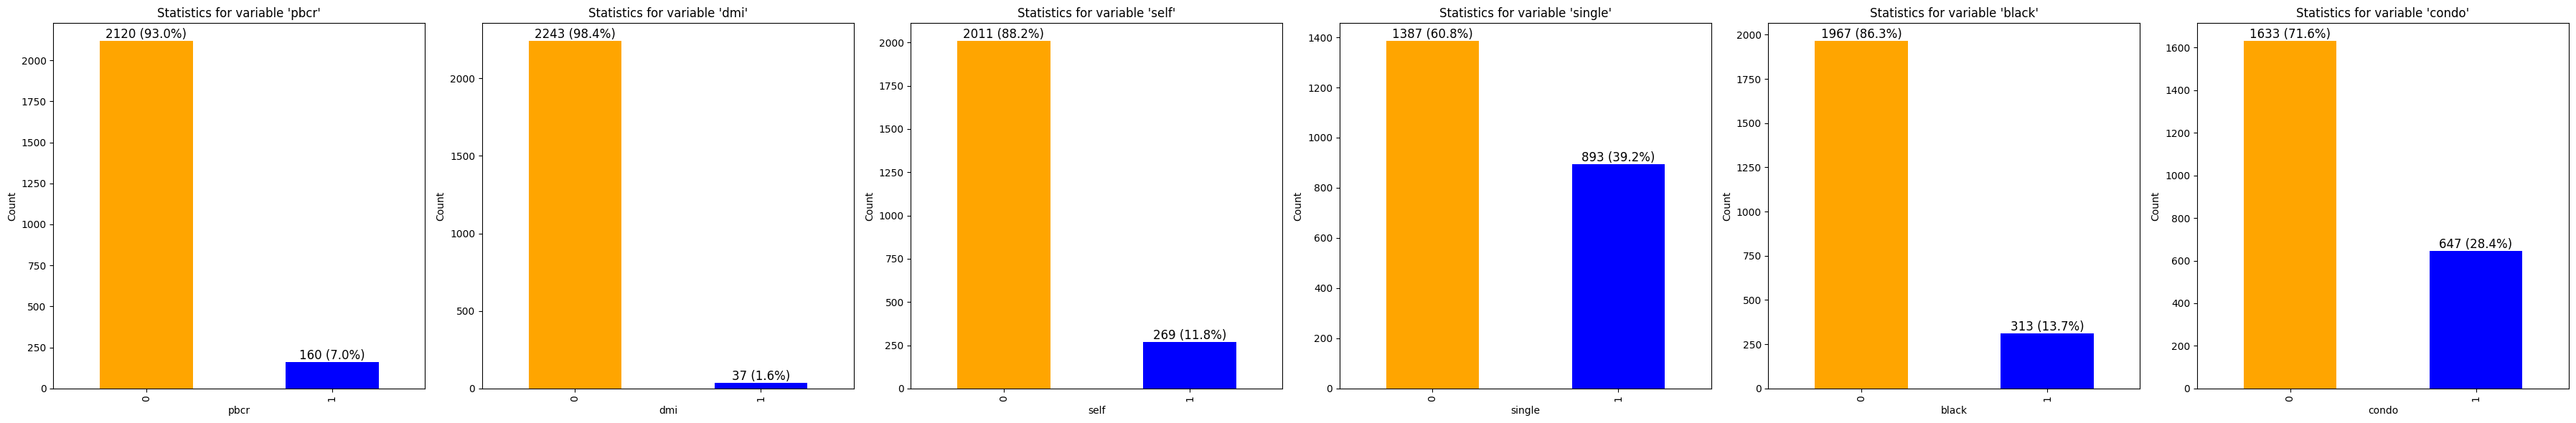

In [ ]:
# Function to plot unique values and counts for each boolean variable
def plot_boolean_stats(df, var_list):
    num_vars = len(var_list)
    fig, axes = plt.subplots(nrows=1, ncols=num_vars, figsize=(num_vars * 6, 6))

    for i, var in enumerate(var_list):
        ax = axes[i] if num_vars > 1 else axes
        unique_values = df[var].value_counts()
        total_count = unique_values.sum()
        percentages = unique_values / total_count * 100
        unique_values.plot(kind='bar', ax=ax, color=['orange', 'blue'])

        ax.set_title(f"Statistics for variable '{var}'")
        ax.set_xlabel(var)
        ax.set_ylabel('Count')

        # Add percentage annotations inside the bars
        for j, count in enumerate(unique_values):
            ax.text(j, count, f"{count} ({percentages[j]:.1f}%)", ha='center', va='bottom', fontsize=12, color='black')

    plt.tight_layout()
    plt.show()

# Print stats for specified boolean variables
plot_boolean_stats(train_data, boolean_vars)

The dataset is pretty unbalanced. One could think about oversampling here

### 2.2.2 Numerical Features

In [ ]:
# List of numerical variables
numerical_vars = ["dir", "hir", "lvr", "ccs", "mcs", "uria"]

# Summary statistics
summary = train_data[numerical_vars].describe()

# Additional statistics
modes = train_data[numerical_vars].mode()
medians = train_data[numerical_vars].median()

print("Summary statistics:")
print(summary)

print("\nMode:")
print(modes)

print("\nMedian:")
print(medians)

Summary statistics:
               dir          hir          lvr          ccs          mcs  \
count  2280.000000  2280.000000  2280.000000  2280.000000  2280.000000   
mean      0.328167     0.253334     0.735877     2.099561     1.716667   
std       0.084720     0.073506     0.176539     1.656082     0.540167   
min       0.000000     0.000000     0.020000     1.000000     1.000000   
25%       0.280000     0.215000     0.651731     1.000000     1.000000   
50%       0.330000     0.260000     0.779167     1.000000     2.000000   
75%       0.370000     0.297000     0.864995     2.000000     2.000000   
max       1.280000     0.730000     1.908333     6.000000     4.000000   

              uria  
count  2280.000000  
mean      3.776754  
std       2.022399  
min       1.800000  
25%       3.100000  
50%       3.200000  
75%       3.900000  
max      10.600000  

Mode:
    dir   hir  lvr  ccs  mcs  uria
0  0.36  0.28  0.8  1.0  2.0   3.2

Median:
dir     0.330000
hir     0.260000
lvr 

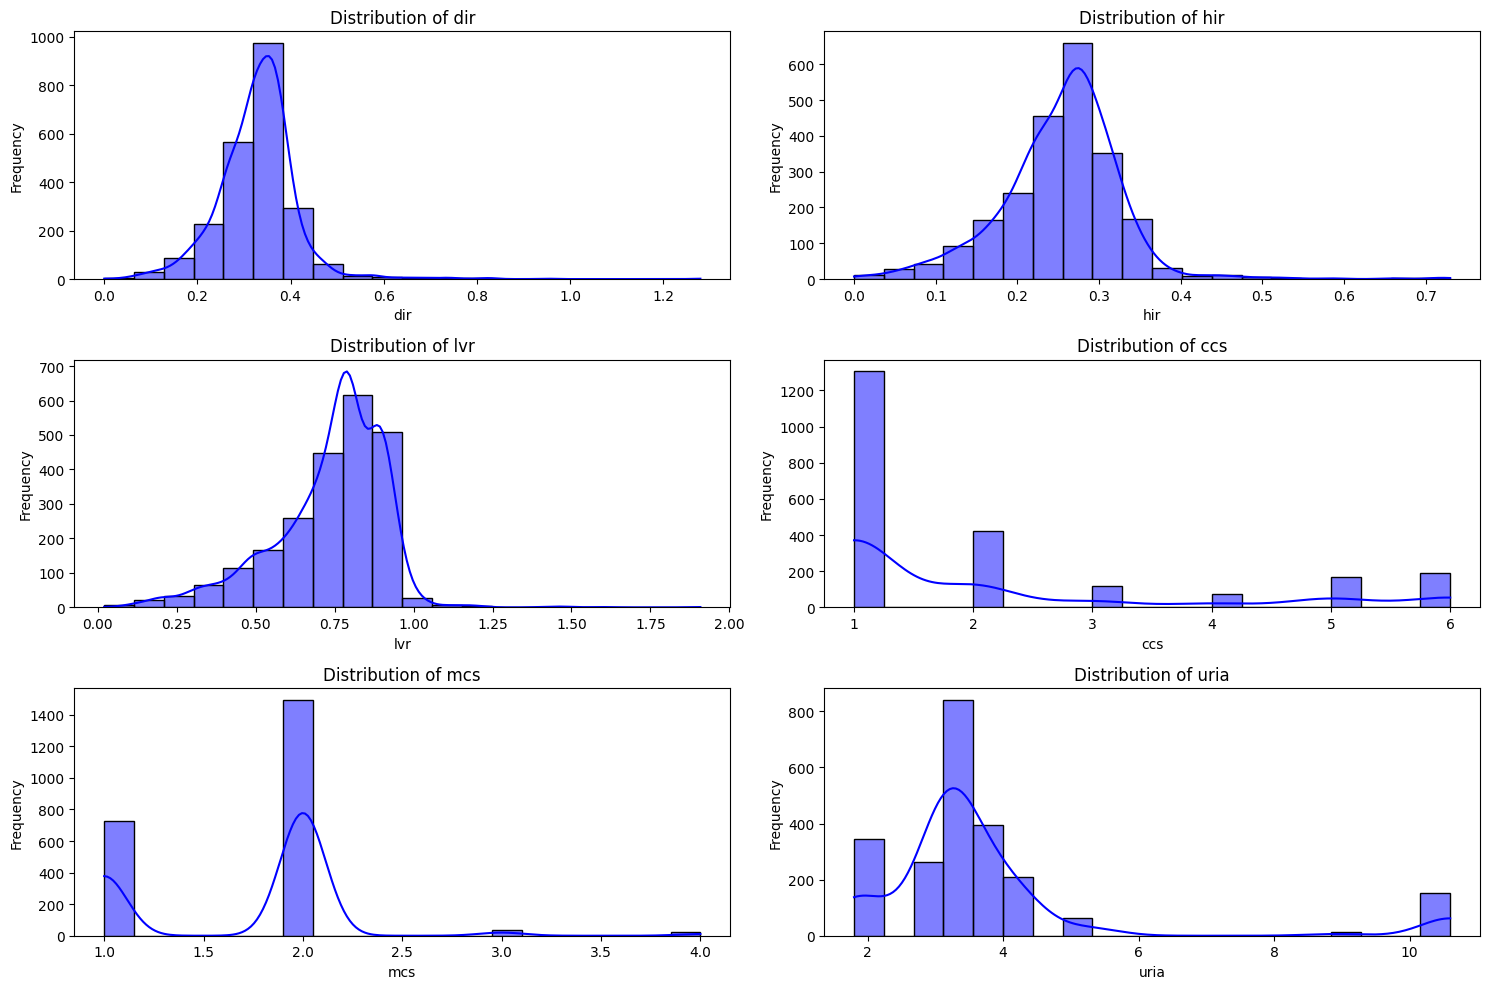

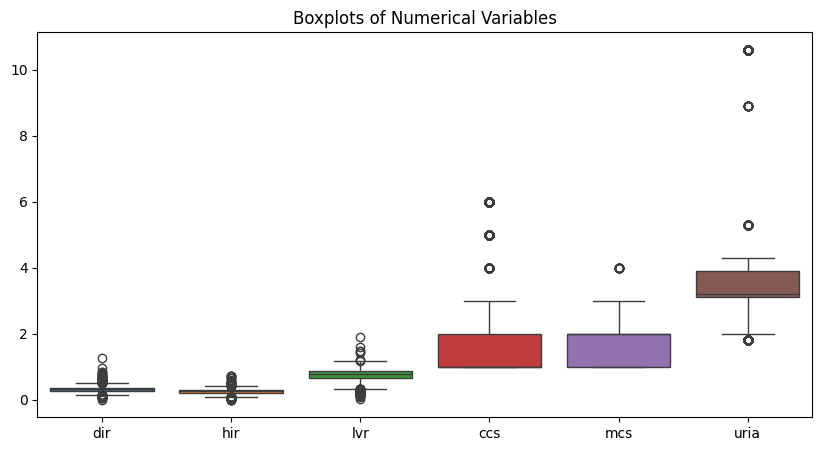

In [ ]:
# Visualization: Histograms and boxplots
plt.figure(figsize=(15, 10))

# Histograms
for i, var in enumerate(numerical_vars, start=1):
    plt.subplot(3, 2, i)  # Adjust layout as necessary
    sns.histplot(train_data[var], kde=True, bins=20, color="blue")
    plt.title(f"Distribution of {var}")
    plt.xlabel(var)
    plt.ylabel("Frequency")

# Displaying histograms
plt.tight_layout()
plt.show()

# Boxplot for an overview of all variables
plt.figure(figsize=(10, 5))
sns.boxplot(data=train_data[numerical_vars])

plt.title("Boxplots of Numerical Variables")
plt.show()

### 2.2.3 Correlation



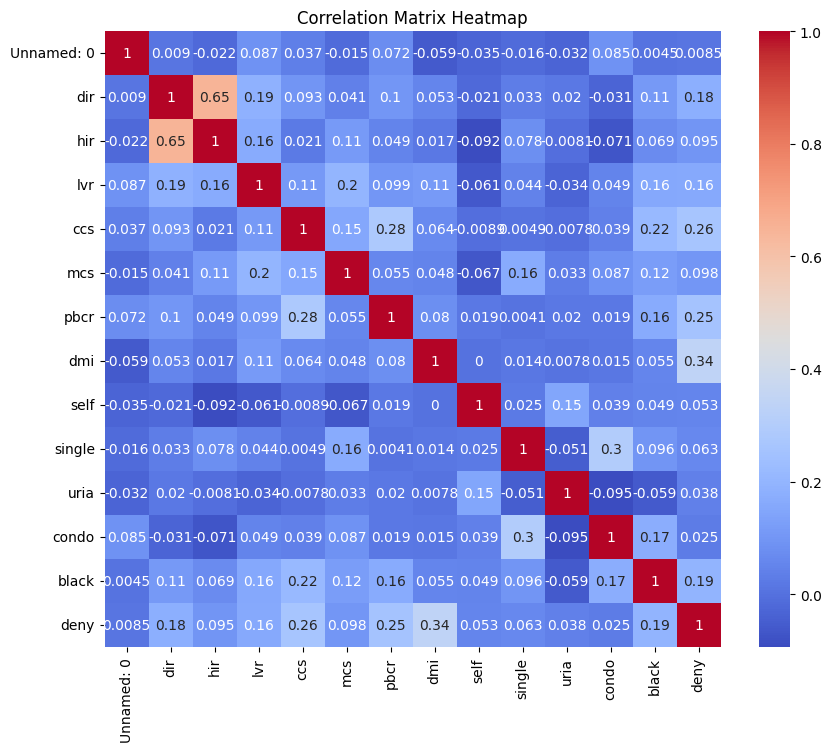

In [ ]:
numerical_vars = ["dir", "hir", "lvr", "ccs", "mcs", "uria"]
boolean_vars = ['pbcr', 'dmi', 'self', 'single', 'condo', 'black']

# Function to compute correlations
def compute_correlations(df):
    numerical_vars = [col for col in df.columns if df[col].dtype in [np.float64, np.int64]]
    binary_vars = [col for col in df.columns if len(df[col].unique()) == 2]

    corr_matrix = pd.DataFrame(index=df.columns, columns=df.columns)

    for num1 in numerical_vars:
        for num2 in numerical_vars:
            if num1 != num2:
                corr_matrix.loc[num1, num2] = df[num1].corr(df[num2])

        for bin1 in binary_vars:
            correlation, _ = pointbiserialr(df[num1], df[bin1])
            corr_matrix.loc[num1, bin1] = correlation
            corr_matrix.loc[bin1, num1] = correlation

    for bin1 in binary_vars:
        for bin2 in binary_vars:
            if bin1 != bin2:
                cont_table = pd.crosstab(df[bin1], df[bin2])
                chi2_stat, _, _, _ = chi2_contingency(cont_table)
                phi_coefficient = np.sqrt(chi2_stat / df.shape[0])
                corr_matrix.loc[bin1, bin2] = phi_coefficient

    return corr_matrix

# Generate the correlation matrix
correlation_matrix = compute_correlations(train_data)

# Fill NaN values with 0 or a sensible default for display
correlation_matrix = correlation_matrix.apply(pd.to_numeric, errors='coerce').fillna(1)

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix.astype(float), annot=True, cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

High correlation only between dir and hir

## 2.3 Bivariate Statistics in combination with goal variable "deny"

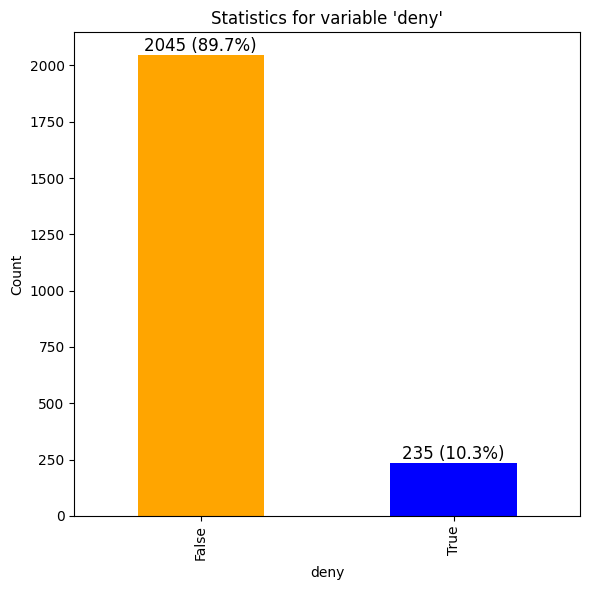

In [ ]:
plot_boolean_stats(train_data, ["deny"])

In our Training data 10% of the mortage applications get denied.
Pretty unbalanced, one could think about oversampling.


#### Binary Variables

In [ ]:
# Create an empty list to store results
results = []

# Iterate over each boolean variable
for var in boolean_vars:
    # Group by the variable and calculate the percentage of denied applications for each category
    var_grouped = train_data.groupby(var)["deny"].mean() * 100

    # Append the results to the list
    for category, percentage in var_grouped.items():
        results.append({'Variable': var, 'Category': category, 'Percentage Denied': percentage})

# Convert the list of dictionaries to a DataFrame
results_df = pd.DataFrame(results)

# Print the results
print(results_df)


   Variable  Category  Percentage Denied
0      pbcr         0           8.160377
1      pbcr         1          38.750000
2       dmi         0           8.961213
3       dmi         1          91.891892
4      self         0           9.696668
5      self         1          14.869888
6    single         0           8.723864
7    single         1          12.765957
8     condo         0           9.797918
9     condo         1          11.591963
10    black         0           7.930859
11    black         1          25.239617


We can observe that the variables pbcr, dmi and black seem to have a huge influence on the application rate.\
We can also see that mortages of black people get denied a lot more often, then from non-coloured people. Anyways we can only interfere correlation no causality yet.\
We could think about removing the variables single, self and condo

#### Categorical Variables
According to the meta data, the variables ccs and mcs are also categorical, but have a senseful order. Let's check their influence on the goal variable

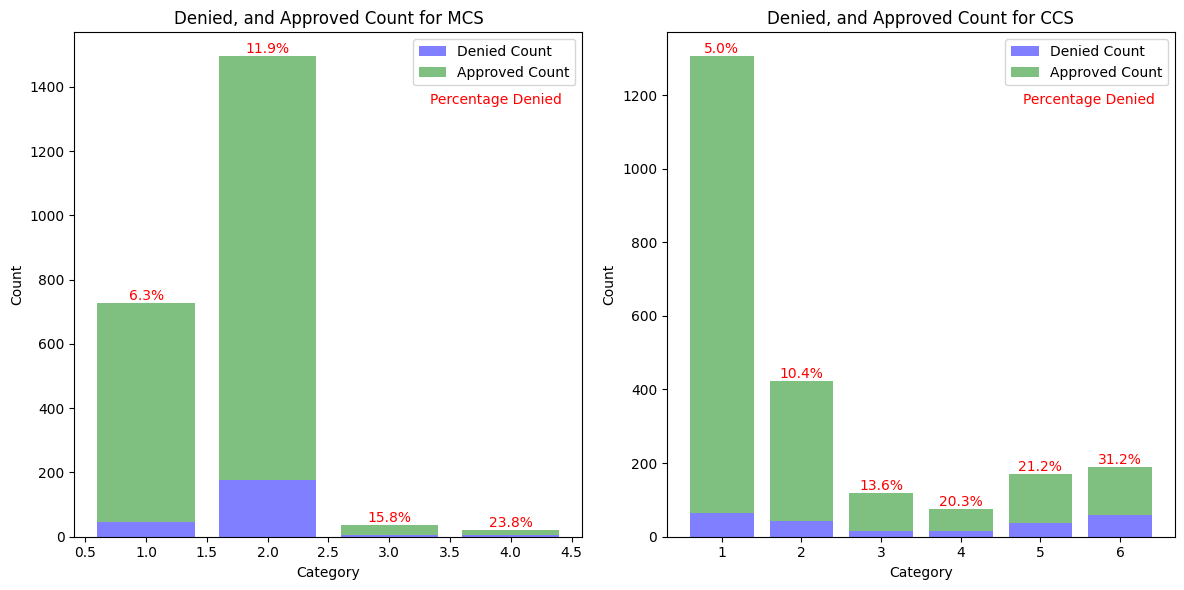

In [ ]:
categorical_variables = ['mcs', 'ccs']

# Create an empty list to store results
results = []

# Iterate over each variable
for var in categorical_variables:
    # Group by the variable and calculate count of denied and approved applications for each category
    var_grouped = train_data.groupby(var)["deny"].value_counts().unstack().fillna(0)

    # Append the results to the list
    for category in var_grouped.index:
        denied_count = var_grouped.loc[category, True]
        approved_count = var_grouped.loc[category, False]
        total_count = denied_count + approved_count
        results.append({'Variable': var, 'Category': category, 'Denied Count': denied_count, 'Approved Count': approved_count, 'Total Count': total_count})

# Convert the list of dictionaries to a DataFrame
results_df = pd.DataFrame(results)

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Iterate over each variable
for idx, var in enumerate(categorical_variables):
    subset = results_df[results_df['Variable'] == var]
    ax = axes[idx]

    # Plot count of denied applications
    ax.bar(subset['Category'], subset['Denied Count'], color='blue', alpha=0.5, label='Denied Count')

    # Plot count of approved applications on top of denied counts
    ax.bar(subset['Category'], subset['Approved Count'], bottom=subset['Denied Count'], color='green', alpha=0.5, label='Approved Count')

    ax.set_ylabel('Count')
    ax.set_xlabel('Category')
    ax.set_title(f'Denied, and Approved Count for {var.upper()}')
    ax.legend()


    # Add percentage text labels inside each bar
    for i, (denied, total) in enumerate(zip(subset['Denied Count'], subset['Total Count'])):
        percentage = denied / total * 100
        ax.text(i + 1, total, f'{percentage:.1f}%', ha='center', va='bottom', color='red')

    # Add legend for percentage denied
    ax.text(0.7, 0.88, 'Percentage Denied', transform=ax.transAxes, color='red', fontsize=10, ha='left', va='top')


plt.tight_layout()
plt.show()

We can observe an almost linear relationship between the percentage of denied mortages and the categories here. So we can leave the variable numerical

# 3 Logistic regression and data transformation

We try several approaches/Ideas.\
First we want to see if the three variables self, single, condo have an influence.\
Afterwards we want to compare the results with and without the variable black\
Then we're trying outlier treatment \


Further ideas, not executed:\
Oversampling due to class imbalance (only about 10% positive cases, which were denied), but our dataset is pretty big.\
Transforming the numerical variables, since they're slightly skewed. Anyways by
dealing with the outliers this problem already get's better and they're not highly skewed.

In [ ]:
# Features and target variable
numerical_vars = ["dir", "hir", "lvr", "ccs", "mcs", "uria"]
boolean_vars = ['pbcr', 'dmi', 'self', 'single', 'condo', 'black']

features = numerical_vars + boolean_vars
X = train_data[features]
y = train_data['deny']


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [ ]:
#Create a function for testing the different ideas for the logistic regression
def logistic_regression_analysis(X_train, y_train, X_test, y_test):
    # Add constant to the predictor variable set
    X_train_const = sm.add_constant(X_train)
    X_test_const = sm.add_constant(X_test)

    # Fit the logistic regression model
    model = sm.Logit(y_train, X_train_const).fit(disp=0)

    # Display the summary of the logistic regression model
    print("Summary of Logistic Regression:")
    print(model.summary())

    # Predict on test data
    y_pred = model.predict(X_test_const)
    y_pred_class = (y_pred > 0.5).astype(int)  # Converting probabilities to class output

    # Calculate confusion matrix and accuracy
    cm = confusion_matrix(y_test, y_pred_class)
    acc = accuracy_score(y_test, y_pred_class)

    # Print the confusion matrix and accuracy
    print("\nConfusion Matrix:")
    print(cm)

    print("\nAccuracy of the model:")
    print(f"{acc * 100:.2f}%")

## 3.1 Simple logistic regression testing the variables

In [ ]:
logistic_regression_analysis(X_train, y_train, X_test, y_test)

Summary of Logistic Regression:
                           Logit Regression Results                           
Dep. Variable:                   deny   No. Observations:                 1710
Model:                          Logit   Df Residuals:                     1697
Method:                           MLE   Df Model:                           12
Date:                Sat, 04 May 2024   Pseudo R-squ.:                  0.3010
Time:                        19:35:16   Log-Likelihood:                -405.20
converged:                       True   LL-Null:                       -579.68
Covariance Type:            nonrobust   LLR p-value:                 2.339e-67
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.7206      0.823    -10.595      0.000     -10.334      -7.107
dir            5.5238      1.441      3.832      0.000       2.699       8.349
hir            0.014

We can see that condo and single are not significant. Similar for hir and uria. Let's remove hir and condo first, since they have the highest p-value. Furthermore hir has a high correlation with dir.

In [ ]:
X_train_new = X_train.drop(['hir', 'condo'], axis=1)
X_test_new = X_test.drop(['hir', 'condo'], axis=1)

logistic_regression_analysis(X_train_new, y_train, X_test_new, y_test)


Summary of Logistic Regression:
                           Logit Regression Results                           
Dep. Variable:                   deny   No. Observations:                 1710
Model:                          Logit   Df Residuals:                     1699
Method:                           MLE   Df Model:                           10
Date:                Sat, 04 May 2024   Pseudo R-squ.:                  0.3010
Time:                        19:35:17   Log-Likelihood:                -405.20
converged:                       True   LL-Null:                       -579.68
Covariance Type:            nonrobust   LLR p-value:                 6.679e-69
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.7157      0.808    -10.787      0.000     -10.299      -7.132
dir            5.5256      1.214      4.551      0.000       3.146       7.905
lvr            2.625

The results stay the same, so we estimate both variables to be not relevant and perhaps even lead to overfitting for other Machine-Learning algorithms, that's why we remove them. Let's try again for uria.

In [ ]:
X_train_new = X_train_new.drop(['uria'], axis=1)
X_test_new = X_test_new.drop(['uria'], axis=1)

logistic_regression_analysis(X_train_new, y_train, X_test_new, y_test)

Summary of Logistic Regression:
                           Logit Regression Results                           
Dep. Variable:                   deny   No. Observations:                 1710
Model:                          Logit   Df Residuals:                     1700
Method:                           MLE   Df Model:                            9
Date:                Sat, 04 May 2024   Pseudo R-squ.:                  0.2987
Time:                        19:35:17   Log-Likelihood:                -406.53
converged:                       True   LL-Null:                       -579.68
Covariance Type:            nonrobust   LLR p-value:                 3.812e-69
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.4431      0.788    -10.712      0.000      -9.988      -6.898
dir            5.5340      1.218      4.542      0.000       3.146       7.922
lvr            2.568

Actually we further improved the quality of the predictions. So we will drop the 3 variables also for the learning later.

In [ ]:
X_train_new = X_train_new.drop(['black'], axis=1)
X_test_new = X_test_new.drop(['black'], axis=1)

logistic_regression_analysis(X_train_new, y_train, X_test_new, y_test)

Summary of Logistic Regression:
                           Logit Regression Results                           
Dep. Variable:                   deny   No. Observations:                 1710
Model:                          Logit   Df Residuals:                     1701
Method:                           MLE   Df Model:                            8
Date:                Sat, 04 May 2024   Pseudo R-squ.:                  0.2914
Time:                        19:35:17   Log-Likelihood:                -410.75
converged:                       True   LL-Null:                       -579.68
Covariance Type:            nonrobust   LLR p-value:                 3.530e-68
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.7235      0.785    -11.111      0.000     -10.262      -7.185
dir            5.7879      1.204      4.809      0.000       3.429       8.147
lvr            2.843

Without the variable "black" the accuracy got 0.5% lower. This is not very
significant and not a direct sign of discrimination. \
The highest influence has dir (debt payments to total income ratio) and dmi (denied mortgage insurance ?), which seem ligitable critea. Also the ratio of size of loan to assessed value of property (lvr) has a big impact.

## 3.2 Logistic regression without outliers

We're trying to treat numerical outliers here.
The relevant variables are "dir" and "lvr" since the other variables are either categorical (in form of numbers) or binary.

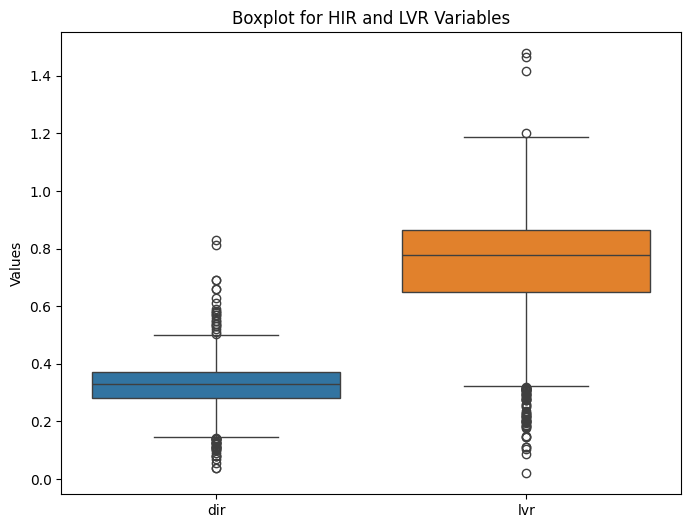

In [ ]:
variables_remove = ["hir", "condo", "uria"]

X_train_new = X_train.drop(variables_remove, axis=1)
X_test_new = X_test.drop(variables_remove, axis=1)

#numerical variables left: "dir" and "lvr".
plt.figure(figsize=(8, 6))
sns.boxplot(data=X_train_new[["dir", "lvr"]])
plt.title('Boxplot for HIR and LVR Variables')
plt.ylabel('Values')
plt.show()


There seem to be a lot of outliers. Therfore we're only going to remove extreme outliers which are more the 3 Standard deviations away from the first or third quartile.

In [ ]:
# Calculate Q1, Q3, and standard deviation
Q1 = X_train_new[['dir', 'lvr']].quantile(0.25)
Q3 = X_train_new[['dir', 'lvr']].quantile(0.75)
std = X_train_new[['dir', 'lvr']].std()

# Calculate the lower and upper bound for each variable
lower_bound = Q1 - 3 * std
upper_bound = Q3 + 3 * std

# Filter out the outliers
condition = ((X_train_new['dir'] >= lower_bound['dir']) & (X_train_new['dir'] <= upper_bound['dir']) &
             (X_train_new['lvr'] >= lower_bound['lvr']) & (X_train_new['lvr'] <= upper_bound['lvr']))
X_train_new_filtered = X_train_new[condition]
y_train_filtered = y_train[condition]

print(f"Original DataFrame shape: {X_train_new.shape}")
print(f"New DataFrame without outliers shape: {X_train_new_filtered.shape}")

Original DataFrame shape: (1710, 9)
New DataFrame without outliers shape: (1692, 9)


We removed 18 Outliers. Let's try the training again.

In [ ]:
logistic_regression_analysis(X_train_new_filtered, y_train_filtered, X_test_new, y_test)

Summary of Logistic Regression:
                           Logit Regression Results                           
Dep. Variable:                   deny   No. Observations:                 1692
Model:                          Logit   Df Residuals:                     1682
Method:                           MLE   Df Model:                            9
Date:                Sat, 04 May 2024   Pseudo R-squ.:                  0.2954
Time:                        19:35:17   Log-Likelihood:                -393.43
converged:                       True   LL-Null:                       -558.34
Covariance Type:            nonrobust   LLR p-value:                 1.217e-65
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.4065      0.843     -9.978      0.000     -10.058      -6.755
dir            5.3003      1.400      3.785      0.000       2.556       8.045
lvr            2.648

The results improved slightly. Se we're deciding to remove outliers the same way in the final training (also to avoid overfitting)

# 3 Training and Evaluation of best model

In [ ]:
# Features and target variable on original data
numerical_vars = ["dir", "lvr", "ccs", "mcs"]
boolean_vars = ['pbcr', 'dmi', 'self', 'single', 'black']

features = numerical_vars + boolean_vars
X = train_data[features]
y = train_data['deny']

#Outlierremoval
# Calculate Q1, Q3, and standard deviation
Q1 = X[['dir', 'lvr']].quantile(0.25)
Q3 = X[['dir', 'lvr']].quantile(0.75)
std = X[['dir', 'lvr']].std()

# Calculate the lower and upper bound for each variable
lower_bound = Q1 - 3 * std
upper_bound = Q3 + 3 * std

# Filter out the outliers
condition = ((X['dir'] >= lower_bound['dir']) & (X['dir'] <= upper_bound['dir']) &
             (X['lvr'] >= lower_bound['lvr']) & (X['lvr'] <= upper_bound['lvr']))
X_final = X[condition]
y_final = y[condition]


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.25, random_state=63)

## 3.1 Random Forest

In [ ]:
# Create a pipeline to normalize numerical features and then train the model
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalize numerical variables
    ('rf', RandomForestClassifier(random_state=1))  # Random Forest model
])

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [6, 8],
    'min_samples_split': [3,4, 5],
    'min_samples_leaf': [4, 6, 8]
}

rf = RandomForestClassifier(random_state=1)

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best model and its performance
best_rf = grid_search.best_estimator_

# Predictions
y_pred = best_rf.predict(X_test)

# Evaluation
print("Best Hyperparameters:", grid_search.best_params_)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Best Hyperparameters: {'max_depth': 6, 'min_samples_leaf': 6, 'min_samples_split': 3, 'n_estimators': 100}

Classification Report:
               precision    recall  f1-score   support

       False       0.93      0.99      0.96       508
        True       0.77      0.31      0.44        55

    accuracy                           0.92       563
   macro avg       0.85      0.65      0.70       563
weighted avg       0.91      0.92      0.91       563


Confusion Matrix:
 [[503   5]
 [ 38  17]]
Accuracy: 0.9236234458259325


##3.2 Logistic regression

In [ ]:
# Create a pipeline for logistic regression
logistic_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalize numerical variables
    ('logistic', LogisticRegression(random_state=1))  # Logistic Regression model
])

# Hyperparameter tuning using GridSearchCV
logistic_param_grid = {
    'logistic__C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter
}

grid_search_logistic = GridSearchCV(logistic_pipeline, logistic_param_grid, cv=5, scoring='accuracy')
grid_search_logistic.fit(X_train, y_train)

# Best model and its performance
best_logistic = grid_search_logistic.best_estimator_

# Predictions
y_pred_logistic = best_logistic.predict(X_test)

# Evaluation
print("Best Hyperparameters:", grid_search_logistic.best_params_)
print("\nClassification Report:\n", classification_report(y_test, y_pred_logistic))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_logistic))
print("Accuracy:", accuracy_score(y_test, y_pred_logistic))

Best Hyperparameters: {'logistic__C': 10}

Classification Report:
               precision    recall  f1-score   support

       False       0.93      0.98      0.96       508
        True       0.69      0.33      0.44        55

    accuracy                           0.92       563
   macro avg       0.81      0.66      0.70       563
weighted avg       0.91      0.92      0.91       563


Confusion Matrix:
 [[500   8]
 [ 37  18]]
Accuracy: 0.9200710479573713


##3.3 XGBoost

In [ ]:


# Create a pipeline with a scaler and XGBoost classifier
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('xgb', xgb.XGBClassifier(random_state=1))  # XGBoost classifier
])

# Hyperparameter tuning using GridSearchCV
xgb_param_grid = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1, 0.3],
    'xgb__subsample': [0.8, 1.0]
}

grid_search_xgb = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=5, scoring='accuracy')
grid_search_xgb.fit(X_train, y_train)

# Best model and its performance
best_xgb = grid_search_xgb.best_estimator_


# Predictions
y_pred_xgb = best_xgb.predict(X_test)

# Evaluation
print("Best Hyperparameters:", grid_search_xgb.best_params_)
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))

Best Hyperparameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__subsample': 1.0}

Classification Report:
               precision    recall  f1-score   support

       False       0.94      0.98      0.96       508
        True       0.72      0.38      0.50        55

    accuracy                           0.93       563
   macro avg       0.83      0.68      0.73       563
weighted avg       0.92      0.93      0.91       563


Confusion Matrix:
 [[500   8]
 [ 34  21]]
Accuracy: 0.9253996447602132


## 3.4 Neurol Network

In [ ]:

# Define the neural network architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Predictions
y_pred_nn = model.predict(X_test)
y_pred_nn = (y_pred_nn > 0.5).astype(int)

# Evaluation
print("\nClassification Report:\n", classification_report(y_test, y_pred_nn))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_nn))
print("Accuracy:", accuracy_score(y_test, y_pred_nn))

Epoch 1/10
43/43 [==============================] - 1s 7ms/step - loss: 0.4581 - accuracy: 0.8532 - val_loss: 0.4125 - val_accuracy: 0.8787
Epoch 2/10
43/43 [==============================] - 0s 3ms/step - loss: 0.3335 - accuracy: 0.9059 - val_loss: 0.3685 - val_accuracy: 0.8787
Epoch 3/10
43/43 [==============================] - 0s 4ms/step - loss: 0.2990 - accuracy: 0.9059 - val_loss: 0.3465 - val_accuracy: 0.8787
Epoch 4/10
43/43 [==============================] - 0s 5ms/step - loss: 0.2841 - accuracy: 0.9103 - val_loss: 0.3489 - val_accuracy: 0.8787
Epoch 5/10
43/43 [==============================] - 0s 3ms/step - loss: 0.2750 - accuracy: 0.9118 - val_loss: 0.3345 - val_accuracy: 0.8817
Epoch 6/10
43/43 [==============================] - 0s 3ms/step - loss: 0.2675 - accuracy: 0.9125 - val_loss: 0.3269 - val_accuracy: 0.8817
Epoch 7/10
43/43 [==============================] - 0s 3ms/step - loss: 0.2612 - accuracy: 0.9155 - val_loss: 0.3243 - val_accuracy: 0.8817
Epoch 8/10
43/43 [==

In [ ]:
#4 Final Training and Prediction

In [ ]:
# Features and target variable
numerical_vars = ["dir", "lvr", "ccs", "mcs"]
boolean_vars = ['pbcr', 'dmi', 'self', 'single', 'black']

features = numerical_vars + boolean_vars
X_train = X_final
y_train = y_final

In [ ]:
X_train.head()

,dir,lvr,ccs,mcs,pbcr,dmi,self,single,black
0,0.221,0.800000,5.0,2.0,0,0,0,0,0
1,0.265,0.921875,2.0,2.0,0,0,0,1,0
2,0.372,0.920398,1.0,2.0,0,0,0,0,0
3,0.320,0.860465,1.0,2.0,0,0,0,0,0
4,0.360,0.600000,1.0,1.0,0,0,0,0,0


In [ ]:
# Features for prediction
X_test_data = test_data[features]
X_test_data.head()

,dir,lvr,ccs,mcs,pbcr,dmi,self,single,black
0,0.280,0.537634,1.0,2.0,0,1,0,0,0
1,0.279,0.751880,1.0,2.0,0,0,0,0,0
2,0.280,0.738255,1.0,2.0,0,0,0,1,0
3,0.265,0.835165,2.0,2.0,1,1,0,0,0
4,0.310,0.882353,4.0,2.0,0,0,0,0,1


In [ ]:
# Define the neural network architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Assuming X_test_data is already defined and preprocessed as necessary
y_pred_new = model.predict(X_test_data)
y_pred_new = (y_pred_new > 0.5).astype(int)

Epoch 1/10
57/57 [==============================] - 1s 6ms/step - loss: 0.4253 - accuracy: 0.8983 - val_loss: 0.3462 - val_accuracy: 0.8978
Epoch 2/10
57/57 [==============================] - 0s 3ms/step - loss: 0.3142 - accuracy: 0.9017 - val_loss: 0.3176 - val_accuracy: 0.8978
Epoch 3/10
57/57 [==============================] - 0s 4ms/step - loss: 0.2901 - accuracy: 0.9050 - val_loss: 0.3029 - val_accuracy: 0.8978
Epoch 4/10
57/57 [==============================] - 0s 3ms/step - loss: 0.2708 - accuracy: 0.9072 - val_loss: 0.2942 - val_accuracy: 0.9000
Epoch 5/10
57/57 [==============================] - 0s 3ms/step - loss: 0.2596 - accuracy: 0.9156 - val_loss: 0.2884 - val_accuracy: 0.9044
Epoch 6/10
57/57 [==============================] - 0s 4ms/step - loss: 0.2521 - accuracy: 0.9172 - val_loss: 0.2980 - val_accuracy: 0.8978
Epoch 7/10
57/57 [==============================] - 0s 3ms/step - loss: 0.2507 - accuracy: 0.9189 - val_loss: 0.2868 - val_accuracy: 0.9022
Epoch 8/10
57/57 [==

In [ ]:
# Optimal hyperparameters
optimal_params = {
    'max_depth': 8,
    'min_samples_leaf': 6,
    'min_samples_split': 3,
    'n_estimators': 200
}

# Create the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('rf', RandomForestClassifier(**optimal_params, random_state=1))  # Random Forest with optimal parameters
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test_data)

In [ ]:
ids = test_data.iloc[:, 0]  # Extract IDs

# Convert integer predictions to boolean (True/False)
y_pred_test_bool = y_pred.astype(bool)

# Combine IDs and predictions into a new DataFrame
results = pd.DataFrame({
    'id': ids,
    'Expected': y_pred_test_bool
})

# Save results to a CSV file
results.to_csv('final_prediction.csv', index=False)

print("Predictions saved to 'final_prediction.csv'.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Predictions saved to 'test_set_predictions.csv'.


In [ ]:
print(results)
print_boolean_stats(results, ["Expected"])

      id  Expected
0     12      True
1     63     False
2     72     False
3     78      True
4     82     False
..   ...       ...
95  2231      True
96  2238     False
97  2240     False
98  2335     False
99  2338     False

[100 rows x 2 columns]
Statistics for variable 'Expected':
Expected
False    83
True     17
Name: count, dtype: int64



### Information: This gives an accuracy of 0.63 in kaggle.

### Looking at feature importance for interpretation:

  feature  importance
5     dmi    0.225462
0     dir    0.201586
1     lvr    0.187088
2     ccs    0.150119
4    pbcr    0.130809
8   black    0.057036
3     mcs    0.019645
7  single    0.016685
6    self    0.011569


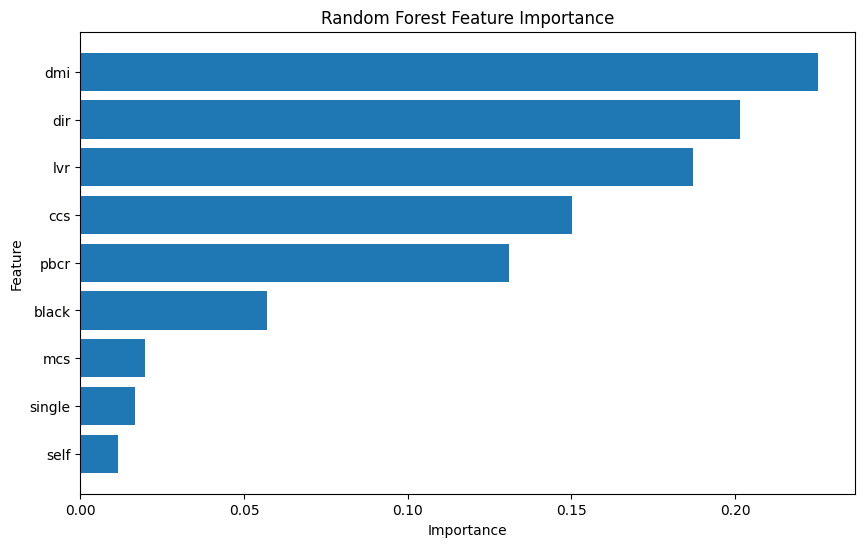

In [ ]:
# Extract the trained Random Forest model from the pipeline
rf_model = pipeline.named_steps['rf']

# Get feature importances
feature_importances = rf_model.feature_importances_

# Assuming you have the feature names in X_train
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Display the DataFrame
print(importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.show()

As alread seamed and assumend in the logistic regression the freature black, doesn't play an important role. Espelcially dir (debt payments to total income ratio) and dmir (denied mortgage insurance ?) play an important role, which makes a lot of sense. Furthermore lvr (ratio of size of loan to assessed value of property),d ccs (consumer credit score from 1 to 6 (a low value being a good score)) and ccs (consumer credit score from 1 to 6 (a low value being a good score)) play important role. In summary the important features seem to be legitimite criteria.

# Extra: Training without Removing Outliers

In previous trys we uploaded results without removing outliers. Actually the accuray on the Test-datatset was better in kaggle, including the outliers in the training. That's why we're including it here. Anyways according to the normal process and our results in the analysis before, we decided to remove outliers in the normal process (Thinking that in real life, we can't see the result on the test_data)

In [ ]:
# Optimal hyperparameters
optimal_params = {
    'max_depth': 8,
    'min_samples_leaf': 6,
    'min_samples_split': 3,
    'n_estimators': 200
}

# Create the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('rf', RandomForestClassifier(**optimal_params, random_state=1))  # Random Forest with optimal parameters
])

# Train the model
pipeline.fit(X, y)

# Make predictions
y_pred = pipeline.predict(X_test_data)

In [ ]:
ids = test_data.iloc[:, 0]  # Extract IDs

# Convert integer predictions to boolean (True/False)
y_pred_test_bool = y_pred.astype(bool)

# Combine IDs and predictions into a new DataFrame
results = pd.DataFrame({
    'id': ids,
    'Expected': y_pred_test_bool
})

print(results)
print_boolean_stats(results, ["Expected"])

      id  Expected
0     12      True
1     63     False
2     72     False
3     78      True
4     82     False
..   ...       ...
95  2231      True
96  2238      True
97  2240     False
98  2335     False
99  2338     False

[100 rows x 2 columns]
Statistics for variable 'Expected':
Expected
False    84
True     16
Name: count, dtype: int64



### Information: This result gives an accuracy of 0.64 in kaggle.